## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [2]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


## Data Preparation & Preprocessing

In [3]:
def crop_brain_contour(image, plot=False):

    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

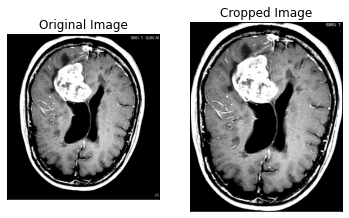

In [4]:
ex_img = cv2.imread('C:/Users/gvasu/OneDrive/Desktop/Research project/Brain tumor Detection/Dataset/yes/y26.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

## Load up the data

In [5]:
def load_data(dir_list, image_size):
    
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        
        for filename in listdir(directory):
#             print(directory +"/" + filename)
#             break
            image = cv2.imread(directory + "/" +  filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [6]:
augmented_yes = 'C:/Users/gvasu/OneDrive/Desktop/Research project/Brain tumor Detection/Dataset/yes' 
augmented_no = 'C:/Users/gvasu/OneDrive/Desktop/Research project/Brain tumor Detection/Dataset/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 3086
X shape is: (3086, 240, 240, 3)
y shape is: (3086, 1)


## Plot sample images


In [7]:
def plot_sample_images(X, y, n=50):
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

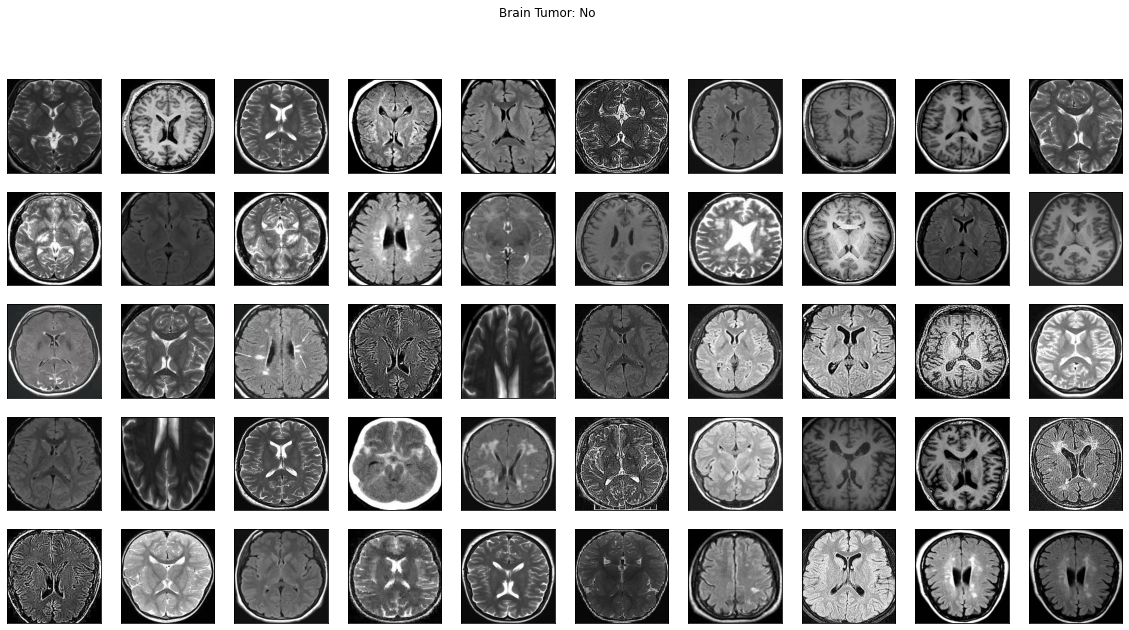

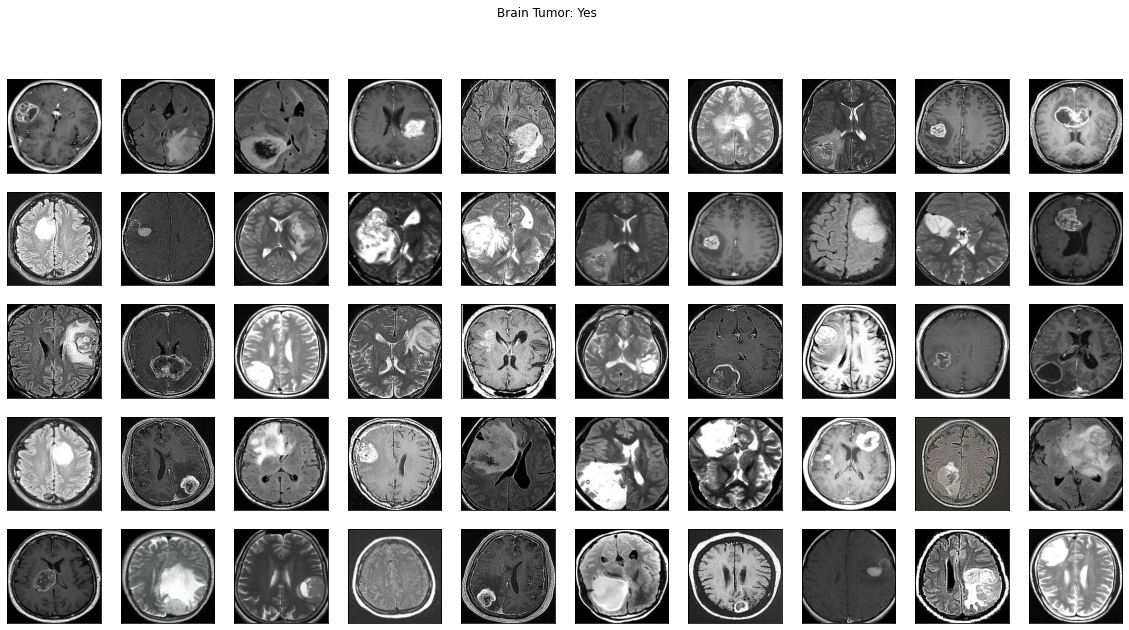

In [8]:
plot_sample_images(X, y)

In [9]:
def split_data(X, y, test_size=0.2):
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 2160
number of development examples = 463
number of test examples = 463
X_train shape: (2160, 240, 240, 3)
Y_train shape: (2160, 1)
X_val (dev) shape: (463, 240, 240, 3)
Y_val (dev) shape: (463, 1)
X_test shape: (463, 240, 240, 3)
Y_test shape: (463, 1)


### Some helper functions

In [12]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [13]:
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

## Build the model

In [14]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    X_input = Input(input_shape) 
    
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) 
    
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid', name='fc')(X) 
    
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

## Define the image shape

In [15]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [16]:
model = build_model(IMG_SHAPE)

In [17]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

## Compile the model

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [20]:
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [21]:
start_time = time.time()

model.fit(x=X_train, y=y_train,validation_split=0.1, batch_size=50, epochs=50, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/50
39/39 [==============================] - 3180s 83s/step - loss: 1.0972 - accuracy: 0.5833 - val_loss: 0.6453 - val_accuracy: 0.6204
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.62.model\assets
Epoch 2/50
39/39 [==============================] - 103s 3s/step - loss: 0.5129 - accuracy: 0.7433 - val_loss: 0.6479 - val_accuracy: 0.5741
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.57.model\assets
Epoch 3/50
39/39 [==============================] - 107s 3s/step - loss: 0.4205 - accuracy: 0.8071 - val_loss: 0.5769 - val_accuracy: 0.6759
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.68.model\assets
Epoch 4/50
39/39 [==============================] - 93s 2s/step - loss: 0.3794 - accuracy: 0.8333 - val_loss: 0.5196 - val_accuracy: 0.7731
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.77.model\assets
Epoch 5/50
39/39 [==============================] - 99s 3s/step - loss: 0.3

In [22]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=1)
loss_v, accuracy_v = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

15/15 [==============================] - 6s 373ms/step - loss: 0.1578 - accuracy: 0.9352
Validation: accuracy = 0.935205  ;  loss_v = 0.157801
Test: accuracy = 0.987963  ;  loss = 0.050510


In [23]:
history = model.history.history

In [24]:
for key in history.keys():
    print(key)

## Plot Loss & Accuracy

In [25]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

## Results

In [27]:
best_model = load_model(filepath='models/cnn-parameters-improvement-06-0.87.model')

In [28]:
best_model.metrics_names

['loss', 'accuracy']

## Evaluate the best model on the testing data

In [29]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

15/15 [==============================] - 6s 396ms/step - loss: 0.2106 - accuracy: 0.9050


In [30]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.21059484779834747
Test Accuracy = 0.9049676060676575


In [31]:
y_test_prob = best_model.predict(X_test)

In [32]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9109311740890689


In [33]:
y_val_prob = best_model.predict(X_val)

In [34]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9166666666666666


## Results Interpretation

In [35]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

In [36]:
data_percentage(y)

Number of examples: 3086
Percentage of positive examples: 48.606610499027866%, number of pos examples: 1500
Percentage of negative examples: 51.393389500972134%, number of neg examples: 1586


In [37]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 2160
Percentage of positive examples: 48.101851851851855%, number of pos examples: 1039
Percentage of negative examples: 51.898148148148145%, number of neg examples: 1121
Validation Data:
Number of examples: 463
Percentage of positive examples: 47.30021598272138%, number of pos examples: 219
Percentage of negative examples: 52.69978401727862%, number of neg examples: 244
Testing Data:
Number of examples: 463
Percentage of positive examples: 52.26781857451404%, number of pos examples: 242
Percentage of negative examples: 47.73218142548596%, number of neg examples: 221
